## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
86537,00021341_018.png,No Finding,18,21341,43,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021341_018.png
89676,00022268_000.png,Pleural_Thickening,0,22268,60,M,PA,3056,2424,0.139,0.139,NaN,/data/images_010/images/00022268_000.png
41855,00010790_031.png,No Finding,31,10790,56,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010790_031.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split("|")).tolist())))
all_labels = [x for x in all_labels if len(x) > 1]
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1 if label in x else 0)
print('All Labels: \n', all_labels)
all_xray_df.sample(3)

All Labels: 
 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81744,00020113_000.png,No Finding,0,20113,37,M,PA,1820,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
91660,00022855_002.png,No Finding,2,22855,57,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
32795,00008574_003.png,No Finding,3,8574,42,F,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['Pneumonia Class'] = all_xray_df['Pneumonia'].map(lambda x: 'pneumonia' if x==1 else 'no pneumonia').astype(str)
#all_xray_df['Pneumonia Class'].
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
92448,00023080_000.png,No Finding,0,23080,46,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,no pneumonia
62505,00015474_000.png,No Finding,0,15474,61,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,no pneumonia
102979,00027453_000.png,No Finding,0,27453,23,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,no pneumonia


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(vargs, test_size=.2, stratify=all_xray_df['Pneumonia Class'], random_state=42)
    p_idx = train_data[train_data['Pneumonia Class']=='pneumonia'].index.tolist()
    np_idx = train_data[train_data['Pneumonia Class']=='no pneumonia'].index.tolist()
    np_sample = sample(np_idx,len(p_idx))
    train_data = train_data.loc[p_idx + np_sample]
    

    val_p_idx = val_data[val_data['Pneumonia Class']=='pneumonia'].index.tolist()
    val_np_idx = val_data[val_data['Pneumonia Class']=='no pneumonia'].index.tolist()
    val_np_sample = sample(val_np_idx,len(val_p_idx))
    val_data = val_data.loc[val_p_idx + val_np_sample]
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)
print('train data:\n', train_data['Pneumonia Class'].value_counts())
print('Validation data:\n', val_data['Pneumonia Class'].value_counts())

train data:
 pneumonia       1145
no pneumonia    1145
Name: Pneumonia Class, dtype: int64
Validation data:
 no pneumonia    286
pneumonia       286
Name: Pneumonia Class, dtype: int64



# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1.0/255.0,
                               horizontal_flip=True,
                               vertical_flip=False,
                               width_shift_range=.2,
                               height_shift_range=.2,
                               shear_range=.1,
                               zoom_range=.1,
                               rotation_range=20)
    
    return my_idg


def make_train_gen(vargs, vargs1):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = vargs
    train_df = vargs1
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'Pneumonia Class',
                                          class_mode = 'binary',
                                          target_size = (224, 224), 
                                          batch_size =10 
                                          )

    return train_gen


def make_val_gen(vargs):
    
    my_val_idg = ImageDataGenerator(rescale=1.0/255.0)
    val_data = vargs
    
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia Class',
                                              class_mode = 'binary',
                                              target_size =(224, 224) , 
                                              batch_size =10 ) 
    
    return val_gen

In [8]:
my_idg = my_image_augmentation()
train_gen = make_train_gen(my_idg, train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 572 validated image filenames belonging to 2 classes.


In [9]:
# iterate over the training generator xray images and accumulate the pixels
total_pixels = 0
mean_sum = 0

for images, _ in train_gen:
    batch_size = images.shape[0]
    pixel_per_image = images.size / batch_size
    total_pixels += pixel_per_image
    mean_sum += np.sum(images)
    
    if total_pixels >= len(train_data):
        break
#calculate the mean pixel value
img_mean = mean_sum / total_pixels
print('Mean Pixel Value: ', img_mean)

total_pixels = 0
mean_sum = 0
squared_diff_sum = 0

for images,_ in train_gen:
    batch_size = images.shape[0]
    pixel_per_image = images.size / batch_size
    total_pixels += pixel_per_image
    mean_sum += np.sum(images)
    squared_diff_sum += np.sum(np.square(images - img_mean))
    
    if total_pixels >= len(train_gen):
        break
# calculate the standard devaition
img_std = np.sqrt(squared_diff_sum / total_pixels)
print('Standard Deviation: ', img_std)

Mean Pixel Value:  5.21299899354273
Standard Deviation:  14.722640784839578


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

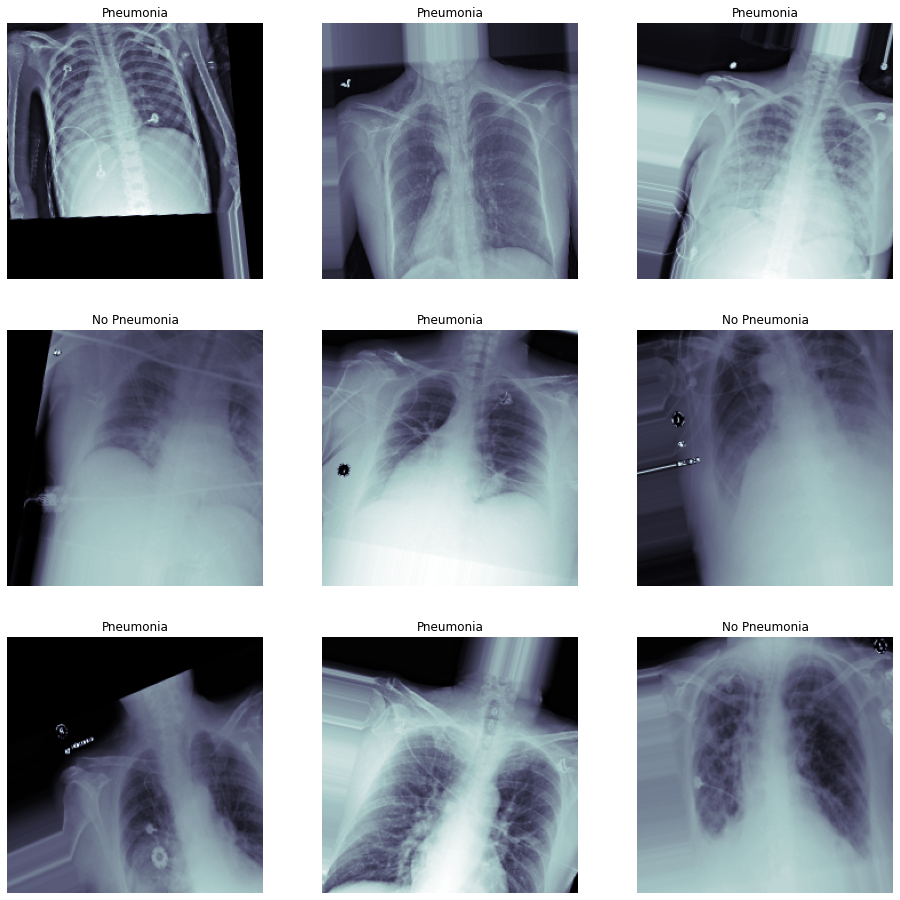

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [13]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(.2))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(.5))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
                 
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)

553467904/553467096 [==============================] - 4s 0us/step


In [15]:
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa57f609910> False
<keras.layers.convolutional.Conv2D object at 0x7fa57c802510> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f5f67d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa57f609fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f6093d0> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f5d9890> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa57f5e1c90> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f5e18d0> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f56cb50> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f571f50> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa57f571f10> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f576e10> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f57cfd0> False
<keras.layers.convolutional.Conv2D object at 0x7fa57f581b10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa57f581f50>

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'auto', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [20]:
## train your model

# Todo
batch_size = 10
steps_per_epoch=len(train_gen) // batch_size 

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY),
                           steps_per_epoch=steps_per_epoch, 
                           epochs = 20, 
                           callbacks = callbacks_list)

Epoch 1/20
22/22 [==============================] - 10s 437ms/step - loss: 0.7637 - binary_accuracy: 0.5000 - val_loss: 0.6747 - val_binary_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 0.67472, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
22/22 [==============================] - 6s 291ms/step - loss: 0.8323 - binary_accuracy: 0.4636 - val_loss: 0.7243 - val_binary_accuracy: 0.4000

Epoch 00002: val_loss did not improve from 0.67472
Epoch 3/20
22/22 [==============================] - 7s 304ms/step - loss: 0.7433 - binary_accuracy: 0.4909 - val_loss: 0.6772 - val_binary_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.67472
Epoch 4/20
22/22 [==============================] - 7s 306ms/step - loss: 0.7288 - binary_accuracy: 0.4864 - val_loss: 0.7452 - val_binary_accuracy: 0.4000

Epoch 00004: val_loss did not improve from 0.67472
Epoch 5/20
22/22 [==============================] - 7s 308ms/step - loss: 0.7378 - binary_accuracy: 0.4318 - val_loss: 0

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

10/10 [==============================] - 0s 22ms/step


In [22]:
print(valY)
pred_Y

[0. 0. 1. 1. 1. 1. 0. 1. 1. 0.]


array([[0.590013  ],
       [0.5605244 ],
       [0.5734457 ],
       [0.59326136],
       [0.6121704 ],
       [0.5045062 ],
       [0.5580903 ],
       [0.56827635],
       [0.5894384 ],
       [0.58101594]], dtype=float32)

In [44]:
def plot_auc(t_y, p_y):
    """function to plot receicer observer characteristics and area under area
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    fpr,tpr,thresholds = roc_curve(t_y, p_y) 
    ax.plot(fpr,tpr, label= '%s (AUC: %0.2f)' % ('Pneumonia', auc(fpr,tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Observer Characteristics')
    


def plot_precision_recall_curve(t_y, p_y):
    """function to plot precsion and recall of the model
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    precision,recall,thresholds = precision_recall_curve(t_y, p_y) 
    ax.plot(recall,precision, label= '%s (AP: %0.2f)' % ('Pneumonia', average_precision_score(t_y,p_y)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precsion and Recall of the Model')
    plt.savefig('precision_recall.png')
    
    

def plot_history(history):
    """function for plotting the history of your model training
    """
    n = len(history.history['loss'])
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(0, n), history.history['loss'], label='train_loss')
    plt.plot(np.arange(0, n), history.history['val_loss'], label='val_loss')
    plt.plot(np.arange(0, n), history.history['binary_accuracy'], label='accuracy')
    plt.plot(np.arange(0, n), history.history['val_binary_accuracy'], label='val_accuracy')
    plt.title('Training Loss and Accuracy of Model')
    plt.xlabel('Epoch')
    plt.ylabel('loss/accuracy')
    plt.legend(loc='upper right')
    plt.savefig('model.histroy.png')
    

In [45]:
def cal_f1(precision, recall):
    return 2 * (precision*recall)/(precision+recall)

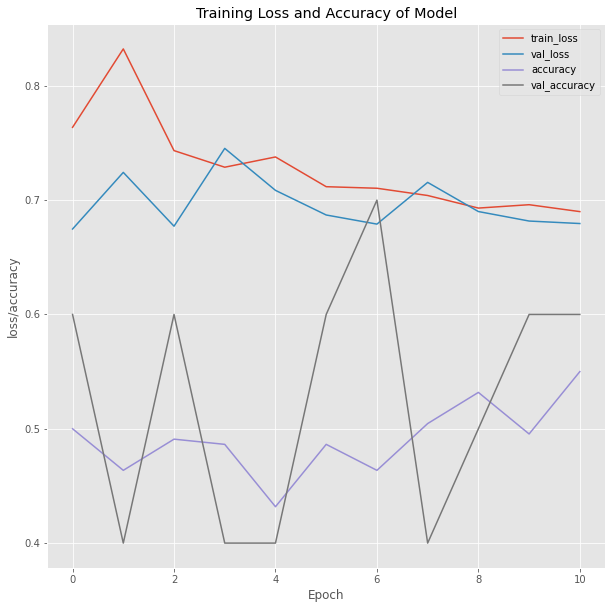

In [46]:
plot_history(history)

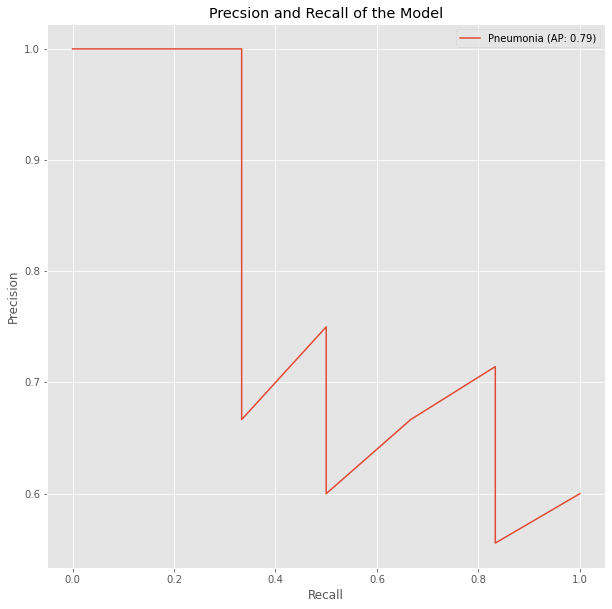

In [47]:
plot_precision_recall_curve(valY, pred_Y)

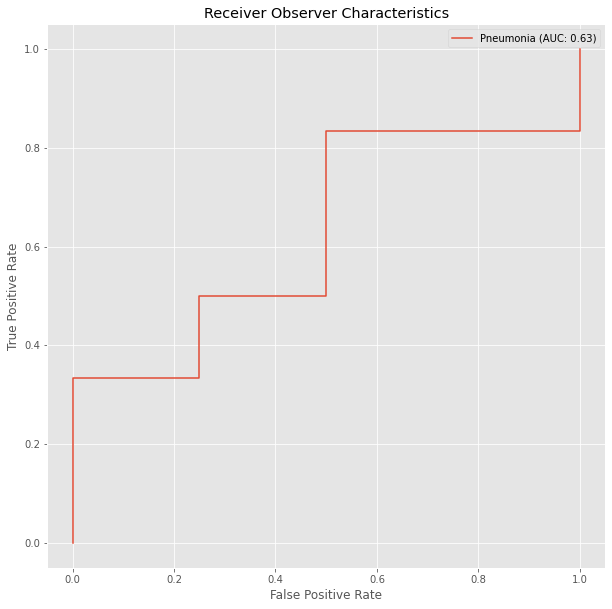

In [48]:
## plot figures
plot_auc(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [38]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# threshold at which precison value is 8.0
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin()
print('Precision: ' +str(precision[idx]))
print('Recall: ' +str(recall[idx]))
print('Threshold: ' +str(thresholds[idx]))
print('F1 score: ' +str(cal_f1(precision[idx],recall[idx])))

# threshold at which recall value is 8.0
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin()
print('Recall: ' +str(precision[idx]))
print('Precision: ' +str(recall[idx]))
print('Threshold: ' +str(thresholds[idx]))
print('F1 score: ' +str(cal_f1(precision[idx],recall[idx])))

Precision: 0.75
Recall: 0.5
Threshold: 0.5894384
F1 score: 0.6
Recall: 0.5555555555555556
Precision: 0.8333333333333334
Threshold: 0.5580903
F1 score: 0.6666666666666667


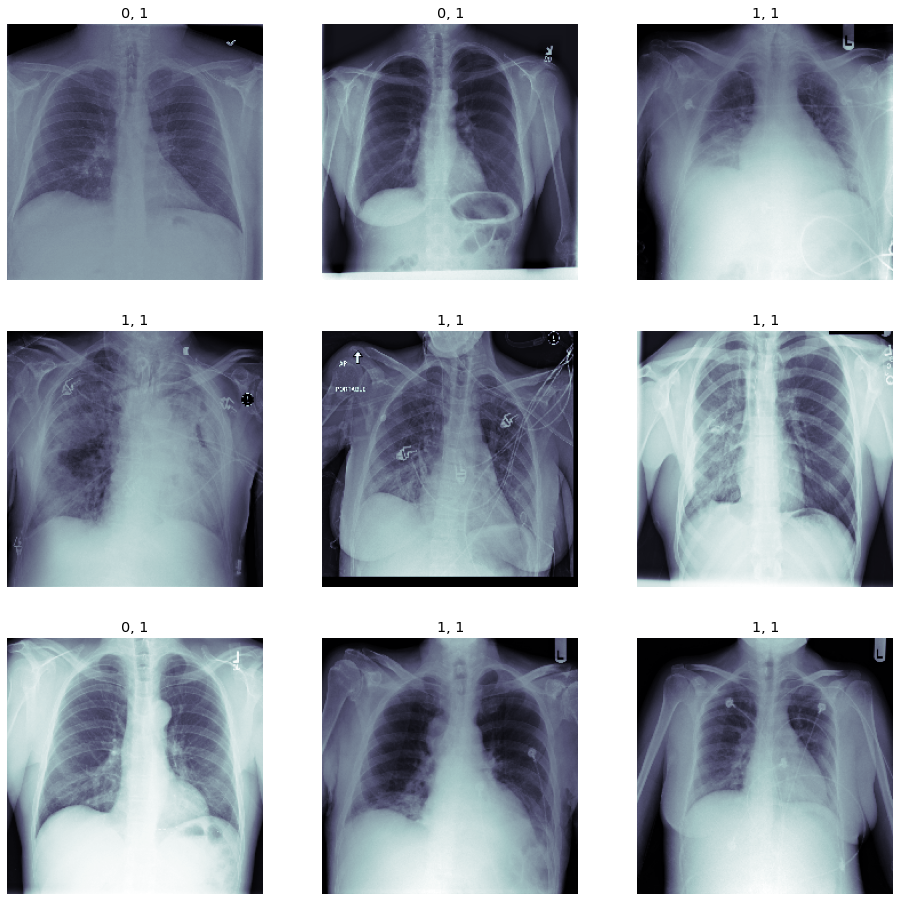

In [39]:
# Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:10], valY[0:10], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.35:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.35: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [40]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)